# Setup

Import necessary modules and define some paths and constants.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import xarray as xr

# To make this notebook's output stable across runs
np.random.seed(42)

# Paths
DATADIR = os.getcwd() + '/../data'

# Some constants
G = 9.80665
CH_CENTER = [46.818, 8.228]
CH_BOUNDING_BOX = [45.66, 47.87, 5.84, 10.98]
DATE_START = '1979-01-01'
DATE_END = '2019-12-31'

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data preparation

## Target variable: precipitation time series

**Dataset**: RhiresD, which is a gridded daily precipitation dataset over Switzerland provided by MeteoSwiss. It is based on a spatial interpolation of rain-gauge data. The grid resolution is 1 km, but the effective resolution is in the order of 15-20 km.


**Aggregations levels**: The gridded dataset has been averaged over different regions:
* 12 climatic regions
* 5 aggregated regions
* the whole country

In [2]:
# Read precipitation file and get events over threshold
precip = pd.read_csv(DATADIR + '/MeteoSwiss/precip_regions.csv')

df_time = pd.to_datetime({
    'year': precip.year,
    'month': precip.month,
    'day': precip.day})
precip.insert(0, "date", df_time, True)

precip = precip[(precip.date >= DATE_START) & (precip.date <= DATE_END)]

precip_p95 = precip.copy()
precip_p99 = precip.copy()

for key, ts in precip.iteritems():
    if key in ['year', 'month', 'day']: continue
    precip_p95[key] = ts > ts.quantile(0.95)
    precip_p99[key] = ts > ts.quantile(0.99)

## Predictors: meteorological fields

**Dataset**: ERA5

In [3]:
# Data extraction functions for ERA5

def rename_dimensions_variables(ds):
    """Rename dimensions and attributes of the given dataset to homogenize data."""
    if 'latitude' in ds.dims:
        ds = ds.rename({'latitude': 'lat'})
    if 'longitude' in ds.dims:
        ds = ds.rename({'longitude': 'lon'})

    return ds


def get_era5_data(files, start=DATE_START, end=DATE_END):
    """Extract ERA5 data for the given file(s) pattern/path."""
    print('Extracting data for the period {} - {}'.format(start, end))
    ds = xr.open_mfdataset(DATADIR + '/ERA5/' + files, combine='by_coords')
    ds = rename_dimensions_variables(ds)
    ds = ds.sel(
        time=slice(start, end)
    )

    return ds

    
def extract_nearest_point_data(ds, lat, lon):
    """Return the time series data for the nearest grid point.

    Arguments:
        ds -- the dataset (xarray Dataset) to extract the data from
        lat -- the latitude coordinate of the point of interest
        lon -- the longitude coordinate of the point of interest

    Example:
    z = xr.open_mfdataset(DATADIR + '/ERA5/geopotential/*.nc', combine='by_coords')
    a = extract_nearest_point_data(z, CH_CENTER[0], CH_CENTER[1])
    """
    return ds.sel({'lat': lat, 'lon': lon}, method="nearest")


def extract_points_around(ds, lat, lon, step_lat, step_lon, nb_lat, nb_lon):
    """Return the time series data for a grid point mesh around the provided coordinates.
    
    Arguments:
    ds -- the dataset (xarray Dataset) to extract the data from
    lat -- the latitude coordinate of the center of the mesh
    lon -- the longitude coordinate of the center of the mesh
    step_lat -- the step in latitude of the mesh
    step_lon -- the step in longitude of the mesh
    nb_lat -- the total number of grid points to extract for the latitude axis (the mesh will be centered)
    nb_lon -- the total number of grid points to extract for the longitude axis (the mesh will be centered)

    Example:
    z = xr.open_mfdataset(DATADIR + '/ERA5/geopotential/*.nc', combine='by_coords')
    a = extract_points_around(z, CH_CENTER[0], CH_CENTER[1], step_lat=1, step_lon=1, nb_lat=3, nb_lon=3)
    """
    lats = np.arange(lat - step_lat * (nb_lat - 1) / 2, lat + step_lat * nb_lat / 2, step_lat)
    lons = np.arange(lon - step_lon * (nb_lon - 1) / 2, lon + step_lon * nb_lon / 2, step_lon)
    xx, yy = np.meshgrid(lats, lons)
    xx = xx.flatten()
    yy = yy.flatten()
    xys = np.column_stack((xx, yy))
    
    data = []
    for xy in xys:
        data.append(extract_nearest_point_data(ds, xy[0], xy[1]))
    
    return data

def get_data_mean_over_box(ds, lats, lons, level = 0):
    """Extract data from points within a bounding box and process the mean.
    
    Arguments:
    ds -- the dataset (xarray Dataset) to extract the data from
    lats -- the min/max latitude coordinates of the bounding box
    lons -- the min/max longitude coordinates of the bounding box
    level -- the desired vertical level
    """
    if len(lats) != 2:
        raise Exception('An array of length 2 is expected for the lats.')
    if len(lons) != 2:
        raise Exception('An array of length 2 is expected for the lons.')

    lat_start = min(lats)
    lat_end = max(lats)

    if (ds.lat[0] > ds.lat[1]):
        lat_start = max(lats)
        lat_end = min(lats)

    if 'level' in ds.dims:
        ds_box = ds.sel(
            lat=slice(lat_start, lat_end), lon=slice(min(lons), max(lons)), level=level
        )
    else:
        ds_box = ds.sel(
            lat=slice(lat_start, lat_end), lon=slice(min(lons), max(lons))
        )

    return ds_box.mean(['lat', 'lon'])


def get_data_mean_over_CH_box(ds, level = 0):
    """Extract data over the bounding box of Switzerland and return the mean time series.
    
    Arguments:
    level -- the desired vertical level
    """
    return get_data_mean_over_box(ds, [CH_BOUNDING_BOX[0], CH_BOUNDING_BOX[1]], [CH_BOUNDING_BOX[2], CH_BOUNDING_BOX[3]], level)

# Unsupervised learning approaches

## PCA

## K-means clustering

# Supervised learning approaches

## Linear regression for precipitation values

In [11]:
# Open data and get the mean value over Switzerland
z = get_era5_data('geopotential/*.nc')
z500_mean = get_data_mean_over_CH_box(z, 500)
mslp = get_era5_data('mslp/*.nc')
mslp_mean = get_data_mean_over_CH_box(mslp)
t2m = get_era5_data('Daymean_era5_T2M_EU_19790101-20210905.nc')
t2m_mean = get_data_mean_over_CH_box(t2m)

# Convert to geopotential height and hPa
z500_mean['z'] = z500_mean['z'] / G
mslp_mean['MSL'] = mslp_mean['MSL'] / 100

Extracting data for the period 1979-01-01 - 2019-12-31
Extracting data for the period 1979-01-01 - 2019-12-31
Extracting data for the period 1979-01-01 - 2019-12-31


Text(0.5, 1.0, 'Temperature 2m')

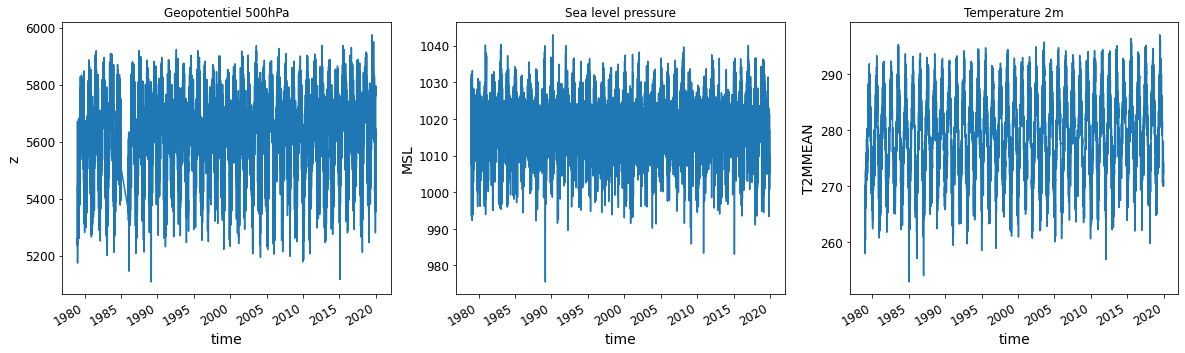

In [15]:
# Plot the time series
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
z500_mean.z.plot(ax=axs[0])
axs[0].set_title('Geopotentiel 500hPa')
mslp_mean.MSL.plot(ax=axs[1])
axs[1].set_title('Sea level pressure')
t2m_mean.T2MMEAN.plot(ax=axs[2])
axs[2].set_title('Temperature 2m')

In [16]:
from sklearn.model_selection import train_test_split

full_set = [z500_mean, mslp_mean, t2m_mean, precip]

#train_set, test_set = train_test_split(full_set, test_size=0.2, random_state=42)

## Logistic regression for extreme events

## Random forest

# Deep learning approaches